In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import os

In [2]:
data_proforma_one = pd.read_excel("/Users/admin/Documents/CKD/data/proforma-records - LTH(OGBOMOSO) - 2018-11-22 08_49_39.xlsx")
data_proforma_two = pd.read_excel("/Users/admin/Documents/CKD/data/Edited proforma-records - LTH(OGBOMOSO) - 2019-01-12 08_02_20.xlsx")

In [3]:
data = pd.concat([data_proforma_one, data_proforma_two], ignore_index=True)
data.columns

Index(['S/N', 'Created At', 'Hospital', 'Patient Id', 'Age of Patient (year)',
       'Gender', 'Blood Pressure (mm/Hg)', 'Weight (kg)',
       'Body temperature (0^c)', 'Hemoglobin (mmol/L)', 'Glucose (mmol/L)',
       'Urea (mmol/L)', 'Creatinine (Umol/L)', 'Sodium (mmol/L)',
       'Calcium (mmol/L)', 'Potassium (mmol/L)', 'Protein Serum (g/dL)',
       'Albumin Serum (g/dL)', 'Phosphorus Serum (mmol/L)',
       'Serum Ferritin (ng/L)', 'Glomerular Filtration Rate (ml/min/1.73 m2)',
       'Intermediate laboratory report(s)',
       'Actual Diagnosed stage of the Acute and Chronic Kidney Disease',
       'Extra Information',
       'Treatment for this stage of the Acute and Chronic Kidney Disease',
       'Comorbidities', 'Date of first appointment',
       'Stage of ACKD at first appointment',
       'Level of education at first appointment',
       'Age of patient at first appointment',
       'Location of Patient at first appointment', 'Lifestyle of patient',
       'Circumstance

In [4]:
data.shape

(511, 33)

In [5]:
columns_with_lnull = ['Calcium (mmol/L)','Extra Information','Serum Ferritin (ng/L)','Phosphorus Serum (mmol/L)',
                      'Albumin Serum (g/dL)','Protein Serum (g/dL)','Hemoglobin (mmol/L)']

minerals_columns = ['Creatinine (Umol/L)', 'Sodium (mmol/L)', 'Potassium (mmol/L)',
                    'Glucose (mmol/L)', 'Urea (mmol/L)']

In [6]:
data =  data.drop(columns_with_lnull, axis=1)

for cols in minerals_columns:
  if data[cols].dtype == 'object':
    data[cols] = (
        data[cols]
        .astype(str)
        .replace(',', '.', regex=True)
        .astype(float)
    )
  else:
    print(f"Skipped {cols}")

Skipped Sodium (mmol/L)
Skipped Glucose (mmol/L)


In [7]:
data.dtypes

S/N                                                                   int64
Created At                                                           object
Hospital                                                             object
Patient Id                                                            int64
Age of Patient (year)                                               float64
Gender                                                               object
Blood Pressure (mm/Hg)                                               object
Weight (kg)                                                         float64
Body temperature (0^c)                                              float64
Glucose (mmol/L)                                                    float64
Urea (mmol/L)                                                       float64
Creatinine (Umol/L)                                                 float64
Sodium (mmol/L)                                                     float64
Potassium (m

In [8]:
for cols in minerals_columns:
  print("Group By against Actual Diagnosed stage of the Acute and Chronic Kidney Disease")
  print(data.groupby('Actual Diagnosed stage of the Acute and Chronic Kidney Disease')[cols].mean())
  print("|-----------------------------------------------------------------------------------------------------------------------|")
  print("\n")

Group By against Actual Diagnosed stage of the Acute and Chronic Kidney Disease
Actual Diagnosed stage of the Acute and Chronic Kidney Disease
GCF == 0, Undefined             738.21284
Stage 5 GFR <15mL/min/1.73m2    514.45480
Name: Creatinine (Umol/L), dtype: float64
|-----------------------------------------------------------------------------------------------------------------------|


Group By against Actual Diagnosed stage of the Acute and Chronic Kidney Disease
Actual Diagnosed stage of the Acute and Chronic Kidney Disease
GCF == 0, Undefined             130.159633
Stage 5 GFR <15mL/min/1.73m2    134.393182
Name: Sodium (mmol/L), dtype: float64
|-----------------------------------------------------------------------------------------------------------------------|


Group By against Actual Diagnosed stage of the Acute and Chronic Kidney Disease
Actual Diagnosed stage of the Acute and Chronic Kidney Disease
GCF == 0, Undefined             4.354488
Stage 5 GFR <15mL/min/1.73m2    

In [9]:
data['Comorbidities'] = data['Comorbidities'].str.title()

In [ ]:
columns_for_modeling = ['Gender', 'Age of Patient (year)', 'Weight (kg)',
                        'Creatinine (Umol/L)', 'Sodium (mmol/L)', 'Potassium (mmol/L)',
                        'Glucose (mmol/L)', 'Urea (mmol/L)', 
                          'Actual Diagnosed stage of the Acute and Chronic Kidney Disease','Target'
                        ]

In [11]:
def clean_blood_pressure(df, column_name):
    """
    Cleans a blood pressure column in a DataFrame.
    
    - Removes trailing slashes
    - Handles missing or invalid values
    - Splits into Systolic (SBP) and Diastolic (DBP) columns
    - Converts to numeric format
    - Keeps the original column

    Args:
    - df (pd.DataFrame): The DataFrame containing the blood pressure column.
    - column_name (str): The column name of blood pressure readings.

    Returns:
    - pd.DataFrame: Updated DataFrame with 'SBP' and 'DBP' columns, keeping the original column.
    """
    # Ensure the column is a string type before processing
    df[column_name] = df[column_name].astype(str)

    # Remove trailing slashes
    df[column_name] = df[column_name].str.rstrip('/')

    # Replace standalone '/' or empty spaces with NaN
    df[column_name] = df[column_name].replace({'/': np.nan, '': np.nan})

    # Split into Systolic (SBP) and Diastolic (DBP) columns
    bp_df = df[column_name].str.split('/', expand=True)
    bp_df.columns = ['SBP', 'DBP']

    # Convert to numeric (invalid values become NaN)
    df['SBP'] = pd.to_numeric(bp_df['SBP'], errors='coerce')
    df['DBP'] = pd.to_numeric(bp_df['DBP'], errors='coerce')

    return df  # No dropping of the original column

data_clean_one = clean_blood_pressure(data, 'Blood Pressure (mm/Hg)')

In [12]:
def encode_kidney_disease_binary(df, column_name):
    """
    Converts the 'Actual Diagnosed stage of the Acute and Chronic Kidney Disease' column into a binary target variable.
    
    - Assigns 1 to "Stage 5 GFR <15mL/min/1.73m2"
    - Assigns 0 to "GCF == 0, Undefined"
    
    Args:
    - df (pd.DataFrame): The DataFrame containing the kidney disease stage column.
    - column_name (str): The column name to encode.

    Returns:
    - pd.DataFrame: Updated DataFrame with a binary target variable.
    """
    # Define binary mapping
    binary_mapping = {
        "Stage 5 GFR <15mL/min/1.73m2": 1,
        "GCF == 0, Undefined": 0
    }

    # Apply encoding
    df['Target'] = df[column_name].map(binary_mapping)

    return df

data_ = encode_kidney_disease_binary(data, 'Actual Diagnosed stage of the Acute and Chronic Kidney Disease')
data_['Target'].value_counts()


Target
1    300
0    211
Name: count, dtype: int64

In [13]:
data_.describe()

,S/N,Patient Id,Age of Patient (year),Weight (kg),Body temperature (0^c),Glucose (mmol/L),Urea (mmol/L),Creatinine (Umol/L),Sodium (mmol/L),Potassium (mmol/L),Glomerular Filtration Rate (ml/min/1.73 m2),Age of patient at first appointment,SBP,DBP,Target
count,511.000000,5.110000e+02,509.000000,308.000000,227.000000,221.000000,485.000000,481.000000,285.000000,329.000000,511.000000,492.000000,503.000000,503.000000,511.000000
mean,132.007828,1.111111e+09,47.756439,65.555260,36.452863,10.455023,22.369938,598.654811,132.774035,4.315258,0.263742,47.676829,148.304175,88.461233,0.587084
std,74.356006,7.761586e+01,18.876472,17.328311,7.377737,18.366039,22.426236,612.836969,9.221452,1.196067,0.616968,18.763488,33.751272,21.054709,0.492840
min,1.000000,1.111111e+09,0.013699,2.560000,-38.000000,2.400000,1.600000,1.582000,103.600000,1.100000,0.000000,5.000000,77.000000,10.000000,0.000000
25%,68.000000,1.111111e+09,34.000000,55.000000,36.400000,5.200000,8.200000,148.000000,128.000000,3.400000,0.000000,34.000000,120.000000,74.000000,0.000000
50%,132.000000,1.111111e+09,48.000000,64.000000,36.800000,7.100000,17.800000,326.000000,134.000000,4.100000,0.070101,48.000000,144.000000,86.000000,1.000000
75%,195.500000,1.111111e+09,63.000000,77.500000,37.300000,10.000000,30.000000,849.000000,138.000000,5.000000,0.289529,62.000000,168.000000,100.000000,1.000000
max,271.000000,1.111111e+09,85.000000,108.700000,59.400000,173.000000,219.000000,3300.000000,177.000000,8.000000,6.027917,85.000000,292.000000,160.000000,1.000000


In [14]:
data_['Actual Diagnosed stage of the Acute and Chronic Kidney Disease'].value_counts()

Actual Diagnosed stage of the Acute and Chronic Kidney Disease
Stage 5 GFR <15mL/min/1.73m2    300
GCF == 0, Undefined             211
Name: count, dtype: int64

In [15]:
data_['Gender'].value_counts()

Gender
Male      325
Female    186
Name: count, dtype: int64

In [16]:
data_[data_['Gender'] == 'Male']['Actual Diagnosed stage of the Acute and Chronic Kidney Disease'].value_counts()

Actual Diagnosed stage of the Acute and Chronic Kidney Disease
Stage 5 GFR <15mL/min/1.73m2    194
GCF == 0, Undefined             131
Name: count, dtype: int64

In [17]:
data_[data_['Gender'] == 'Female']['Actual Diagnosed stage of the Acute and Chronic Kidney Disease'].value_counts()

Actual Diagnosed stage of the Acute and Chronic Kidney Disease
Stage 5 GFR <15mL/min/1.73m2    106
GCF == 0, Undefined              80
Name: count, dtype: int64

In [18]:
data_.groupby('Actual Diagnosed stage of the Acute and Chronic Kidney Disease')['Age of Patient (year)'].mean()

Actual Diagnosed stage of the Acute and Chronic Kidney Disease
GCF == 0, Undefined             46.803828
Stage 5 GFR <15mL/min/1.73m2    48.420091
Name: Age of Patient (year), dtype: float64

In [19]:
# group by the Actual Diagnosed star of acute and ckd to the average weight on both sides
data_.groupby('Actual Diagnosed stage of the Acute and Chronic Kidney Disease')['Weight (kg)'].mean()

Actual Diagnosed stage of the Acute and Chronic Kidney Disease
GCF == 0, Undefined             74.2500
Stage 5 GFR <15mL/min/1.73m2    65.3234
Name: Weight (kg), dtype: float64

Text(0.5, 0, 'Kidney Disease Stage')

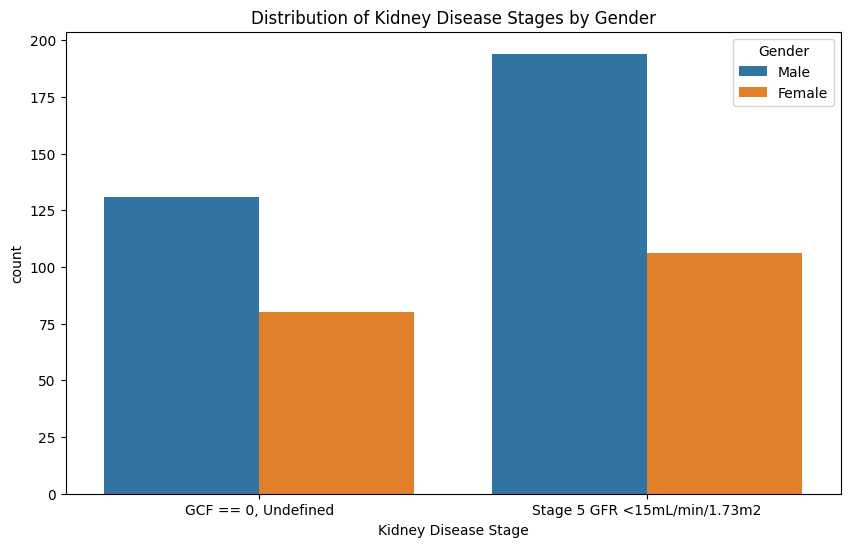

In [20]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Actual Diagnosed stage of the Acute and Chronic Kidney Disease', hue='Gender', data=data_)
plt.title('Distribution of Kidney Disease Stages by Gender')
plt.xlabel('Kidney Disease Stage')

<Figure size 1200x1000 with 0 Axes>

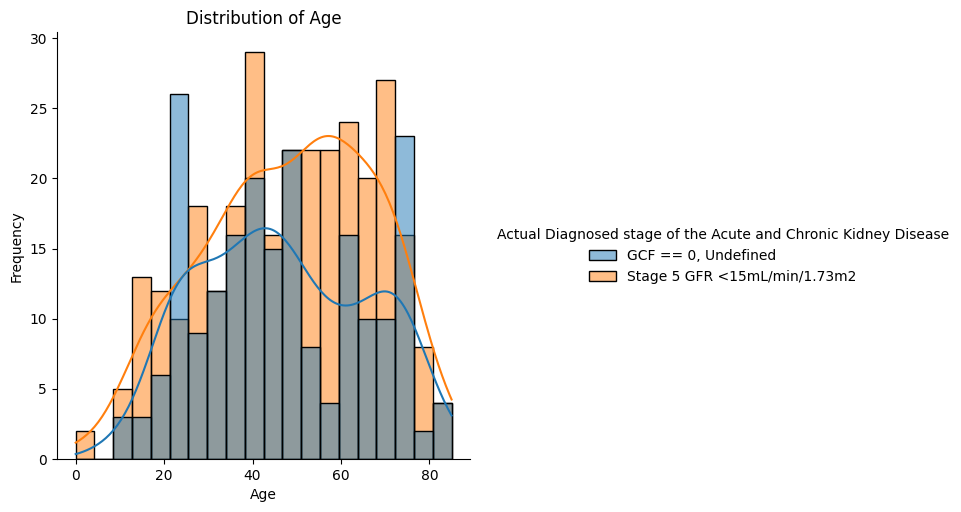

In [21]:
plt.figure(figsize=(12,10))
sns.displot(data=data_, x='Age of Patient (year)', hue='Actual Diagnosed stage of the Acute and Chronic Kidney Disease',bins=20, kde=True) # Changed this line
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

<Figure size 1200x1000 with 0 Axes>

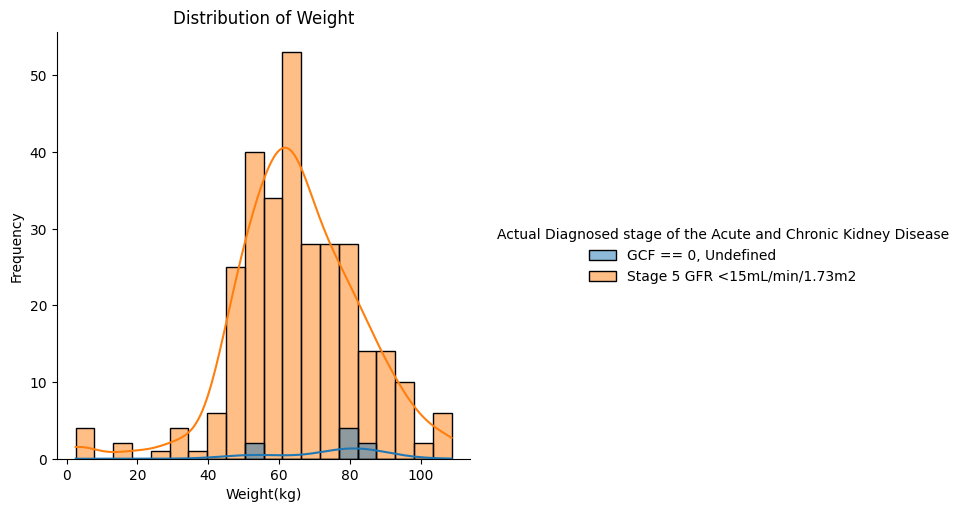

In [22]:
plt.figure(figsize=(12,10))
sns.displot(data=data_, x='Weight (kg)', hue='Actual Diagnosed stage of the Acute and Chronic Kidney Disease',bins=20, kde=True) # Changed this line
plt.title('Distribution of Weight')
plt.xlabel('Weight(kg)')
plt.ylabel('Frequency')
plt.show()

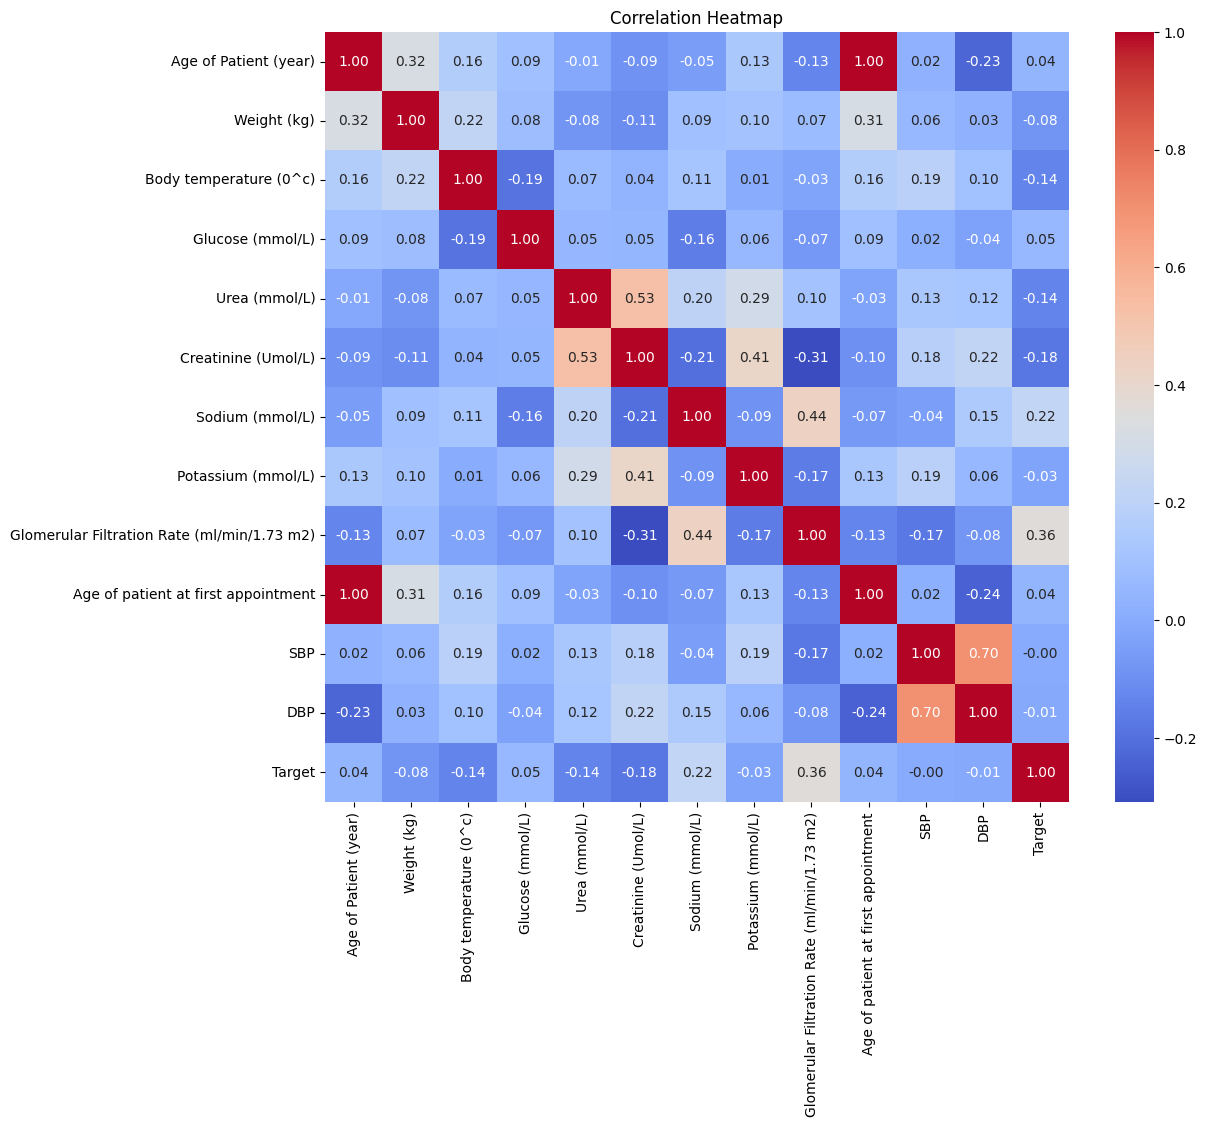

In [23]:
numerical_columns = data_.select_dtypes(include=[np.number]).columns.tolist()
numerical_columns.remove('S/N')
numerical_columns.remove('Patient Id')

correlation_table = data_[numerical_columns].corr()
plt.figure(figsize=(12,10))
sns.heatmap(correlation_table, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

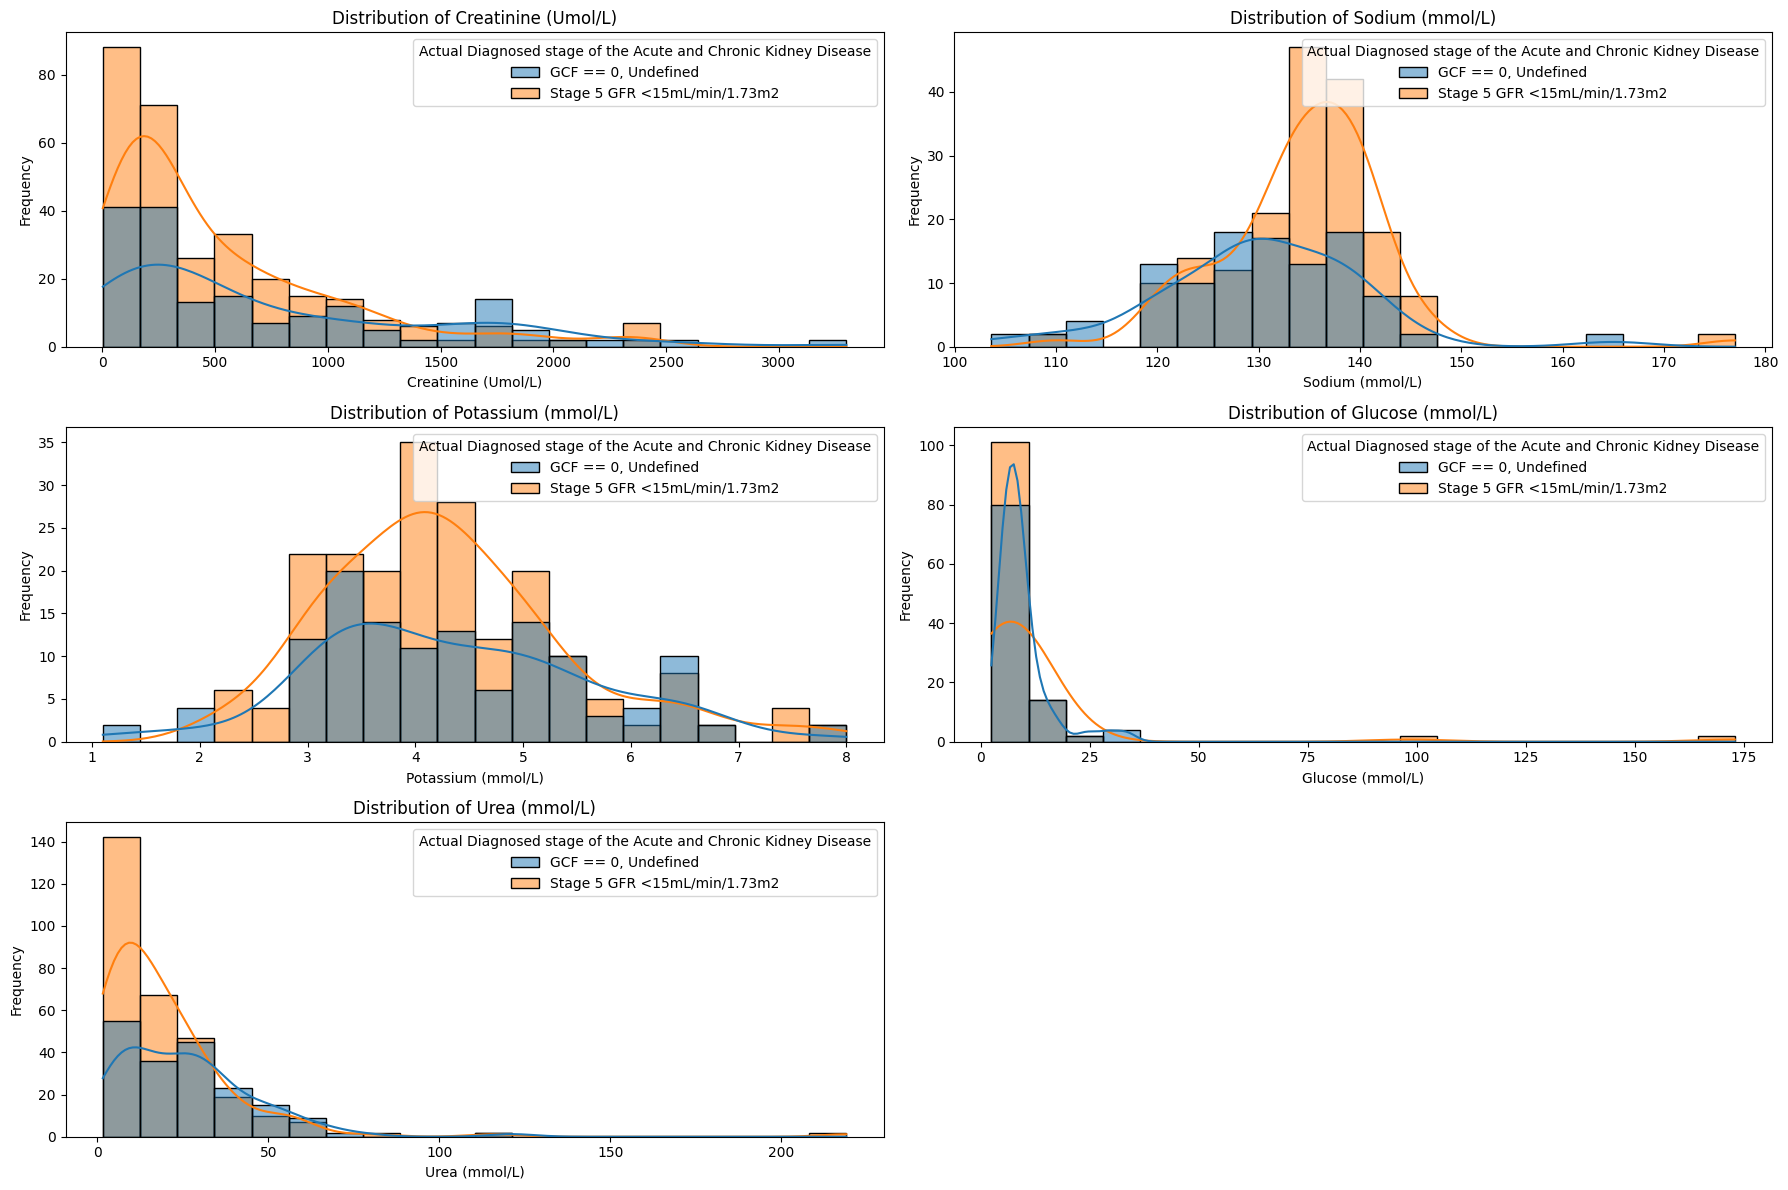

In [24]:
fig, axes = plt.subplots(nrows=(len(minerals_columns) + 1) // 2, ncols=2, figsize=(18, 12)) 
axes = axes.flatten()

# Loop over the mineral columns and generate a plot for each
for idx, col in enumerate(minerals_columns):
    sns.histplot(data=data_, x=col, hue='Actual Diagnosed stage of the Acute and Chronic Kidney Disease',
                 bins=20, kde=True, ax=axes[idx]) 
    axes[idx].set_title(f'Distribution of {col}')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')

for idx in range(len(minerals_columns), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

In [25]:
data_.isnull().sum().sort_values(ascending=False)

Glucose (mmol/L)                                                    290
Body temperature (0^c)                                              284
Sodium (mmol/L)                                                     226
Weight (kg)                                                         203
Potassium (mmol/L)                                                  182
Intermediate laboratory report(s)                                   111
Level of education at first appointment                              43
Creatinine (Umol/L)                                                  30
Urea (mmol/L)                                                        26
Comorbidities                                                        26
Circumstances surrounding first appointment                          20
Age of patient at first appointment                                  19
Treatment for this stage of the Acute and Chronic Kidney Disease     14
Lifestyle of patient                                            

In [ ]:
def smart_class_based_imputation(df, target_column, columns_to_impute=None, method='median_with_noise', noise_factor=0.1, random_state=42):
    """
    Smart imputation function that fills missing values based on target class statistics
    with optional variation to make the imputation more robust.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing the data
    target_column : str
        Name of the target column to group by
    columns_to_impute : list or None
        List of columns to impute. If None, imputes all numeric columns with missing values
    method : str, default 'median_with_noise'
        Imputation method:
        - 'median': Simple median imputation by class
        - 'median_with_noise': Median + random noise based on class standard deviation
        - 'normal_distribution': Sample from normal distribution (class mean, class std)
    noise_factor : float, default 0.1
        Factor to control the amount of noise (0.1 = 10% of std deviation)
    random_state : int, default 42
        Random state for reproducibility
    
    Returns:
    --------
    pd.DataFrame: DataFrame with imputed values
    dict: Imputation statistics for each class and column
    """
    
    np.random.seed(random_state)
    df_imputed = df.copy()
    imputation_stats = {}
    
    # If no columns specified, find all numeric columns with missing values
    if columns_to_impute is None:
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        columns_to_impute = [col for col in numeric_cols if df[col].isnull().sum() > 0]
    
    # Remove target column from imputation if it's in the list
    if target_column in columns_to_impute:
        columns_to_impute.remove(target_column)
    
    print(f"Imputing {len(columns_to_impute)} columns using {method} method...")
    
    for col in columns_to_impute:
        if col not in df.columns:
            print(f"Warning: Column '{col}' not found in DataFrame")
            continue
            
        imputation_stats[col] = {}
        missing_count = df[col].isnull().sum()
        
        if missing_count == 0:
            print(f"No missing values in '{col}', skipping...")
            continue
            
        print(f"Imputing {missing_count} missing values in '{col}'")
        
        # Get unique classes in target column
        classes = df[target_column].unique()
        
        for target_class in classes:
            if pd.isna(target_class):
                continue
                
            # Get data for this class
            class_mask = (df[target_column] == target_class)
            class_data = df[class_mask][col].dropna()
            
            if len(class_data) == 0:
                print(f"Warning: No non-missing values for class '{target_class}' in column '{col}'")
                continue
            
            # Calculate class statistics
            class_median = class_data.median()
            class_mean = class_data.mean()
            class_std = class_data.std()
            
            # Store statistics
            imputation_stats[col][target_class] = {
                'median': class_median,
                'mean': class_mean,
                'std': class_std,
                'count': len(class_data)
            }
            
            # Find missing values for this class
            missing_mask = class_mask & df[col].isnull()
            missing_indices = df[missing_mask].index
            
            if len(missing_indices) == 0:
                continue
            
            # Generate imputed values based on method
            if method == 'median':
                imputed_values = np.full(len(missing_indices), class_median)
                
            elif method == 'median_with_noise':
                # Add controlled noise around median
                noise_std = class_std * noise_factor if not pd.isna(class_std) and class_std > 0 else 0
                noise = np.random.normal(0, noise_std, len(missing_indices))
                imputed_values = class_median + noise
                
            elif method == 'normal_distribution':
                # Sample from normal distribution of the class
                if pd.isna(class_std) or class_std == 0:
                    imputed_values = np.full(len(missing_indices), class_mean)
                else:
                    imputed_values = np.random.normal(class_mean, class_std, len(missing_indices))
            
            else:
                raise ValueError(f"Unknown method: {method}")
            
            # Ensure non-negative values for certain medical measurements
            if any(keyword in col.lower() for keyword in ['creatinine', 'sodium', 'potassium', 'glucose', 'urea', 'weight', 'age']):
                imputed_values = np.maximum(imputed_values, 0.1)  # Minimum positive value
            
            # Apply imputed values
            df_imputed.loc[missing_indices, col] = imputed_values
            
            print(f"  Class '{target_class}': Imputed {len(missing_indices)} values "
                  f"(median={class_median:.2f}, std={class_std:.2f})")
    
    return df_imputed, imputation_stats


def analyze_imputation_quality(original_df, imputed_df, target_column, columns_analyzed=None):
    """
    Analyze the quality of imputation by comparing distributions before and after imputation.
    
    Parameters:
    -----------
    original_df : pd.DataFrame
        Original DataFrame with missing values
    imputed_df : pd.DataFrame  
        DataFrame after imputation
    target_column : str
        Target column name
    columns_analyzed : list or None
        Columns to analyze. If None, analyzes all numeric columns
    """
    
    if columns_analyzed is None:
        columns_analyzed = imputed_df.select_dtypes(include=[np.number]).columns
    
    print("\n" + "="*80)
    print("IMPUTATION QUALITY ANALYSIS")
    print("="*80)
    
    for col in columns_analyzed:
        if col == target_column:
            continue
            
        missing_count = original_df[col].isnull().sum()
        if missing_count == 0:
            continue
            
        print(f"\nColumn: {col}")
        print("-" * 50)
        
        for target_class in original_df[target_column].unique():
            if pd.isna(target_class):
                continue
                
            class_mask = (original_df[target_column] == target_class)
            
            # Original statistics (excluding missing values)
            orig_data = original_df[class_mask][col].dropna()
            imputed_data = imputed_df[class_mask][col]
            
            if len(orig_data) == 0:
                continue
            
            print(f"  Class '{target_class}':")
            print(f"    Original - Mean: {orig_data.mean():.2f}, Median: {orig_data.median():.2f}, Std: {orig_data.std():.2f}")
            print(f"    Imputed  - Mean: {imputed_data.mean():.2f}, Median: {imputed_data.median():.2f}, Std: {imputed_data.std():.2f}")
            
            missing_in_class = class_mask.sum() - len(orig_data)
            print(f"    Missing values imputed: {missing_in_class}")

In [27]:
# Apply the smart class-based imputation
data_imputed, imputation_stats = smart_class_based_imputation(
    df=data_, 
    target_column='Actual Diagnosed stage of the Acute and Chronic Kidney Disease',
    method='median_with_noise',
    noise_factor=0.15,  # 15% variation around the median
    random_state=42
)

# Check missing values after imputation
print("\nMissing values after imputation:")
print(data_imputed.isnull().sum().sort_values(ascending=False))

Imputing 11 columns using median_with_noise method...
Imputing 2 missing values in 'Age of Patient (year)'
  Class 'GCF == 0, Undefined': Imputed 2 values (median=45.00, std=18.69)
Imputing 203 missing values in 'Weight (kg)'
  Class 'GCF == 0, Undefined': Imputed 203 values (median=79.00, std=13.47)
Imputing 284 missing values in 'Body temperature (0^c)'
  Class 'GCF == 0, Undefined': Imputed 97 values (median=37.00, std=3.04)
  Class 'Stage 5 GFR <15mL/min/1.73m2': Imputed 187 values (median=36.70, std=9.92)
Imputing 290 missing values in 'Glucose (mmol/L)'
  Class 'GCF == 0, Undefined': Imputed 111 values (median=8.00, std=5.81)
  Class 'Stage 5 GFR <15mL/min/1.73m2': Imputed 179 values (median=6.20, std=24.26)
Imputing 26 missing values in 'Urea (mmol/L)'
  Class 'GCF == 0, Undefined': Imputed 24 values (median=24.00, std=19.93)
  Class 'Stage 5 GFR <15mL/min/1.73m2': Imputed 2 values (median=13.80, std=23.56)
Imputing 30 missing values in 'Creatinine (Umol/L)'
  Class 'GCF == 0, U

In [28]:
# Analyze the quality of the imputation
analyze_imputation_quality(data_, data_imputed, 'Actual Diagnosed stage of the Acute and Chronic Kidney Disease')

# Display imputation statistics
print("\n" + "="*80)
print("IMPUTATION STATISTICS BY CLASS")
print("="*80)

for col, class_stats in imputation_stats.items():
    print(f"\nColumn: {col}")
    print("-" * 50)
    for class_name, stats in class_stats.items():
        print(f"  {class_name}:")
        print(f"    Count: {stats['count']}, Median: {stats['median']:.2f}, Mean: {stats['mean']:.2f}, Std: {stats['std']:.2f}")


IMPUTATION QUALITY ANALYSIS

Column: Age of Patient (year)
--------------------------------------------------
  Class 'GCF == 0, Undefined':
    Original - Mean: 46.80, Median: 45.00, Std: 18.69
    Imputed  - Mean: 46.79, Median: 45.00, Std: 18.60
    Missing values imputed: 2
  Class 'Stage 5 GFR <15mL/min/1.73m2':
    Original - Mean: 48.42, Median: 50.00, Std: 19.01
    Imputed  - Mean: 48.42, Median: 50.00, Std: 19.01
    Missing values imputed: 0

Column: Weight (kg)
--------------------------------------------------
  Class 'GCF == 0, Undefined':
    Original - Mean: 74.25, Median: 79.00, Std: 13.47
    Imputed  - Mean: 78.75, Median: 79.00, Std: 3.21
    Missing values imputed: 203
  Class 'Stage 5 GFR <15mL/min/1.73m2':
    Original - Mean: 65.32, Median: 64.00, Std: 17.38
    Imputed  - Mean: 65.32, Median: 64.00, Std: 17.38
    Missing values imputed: 0

Column: Body temperature (0^c)
--------------------------------------------------
  Class 'GCF == 0, Undefined':
    Orig

In [30]:
data_imputed.isnull().sum().sort_values(ascending=False)

Intermediate laboratory report(s)                                   111
Level of education at first appointment                              43
Comorbidities                                                        26
Circumstances surrounding first appointment                          20
Treatment for this stage of the Acute and Chronic Kidney Disease     14
Lifestyle of patient                                                 10
Date of first appointment                                            10
Blood Pressure (mm/Hg)                                                8
Location of Patient at first appointment                              8
S/N                                                                   0
DBP                                                                   0
SBP                                                                   0
Age of patient at first appointment                                   0
Stage of ACKD at first appointment                              

In [31]:
data_modelling = data_imputed[columns_for_modeling]
data_modelling.isnull().sum().sort_values(ascending=False)

Comorbidities                                                     26
Gender                                                             0
Age of Patient (year)                                              0
Weight (kg)                                                        0
Creatinine (Umol/L)                                                0
Sodium (mmol/L)                                                    0
Potassium (mmol/L)                                                 0
Glucose (mmol/L)                                                   0
Urea (mmol/L)                                                      0
Actual Diagnosed stage of the Acute and Chronic Kidney Disease     0
Target                                                             0
dtype: int64

In [32]:
data_modelling.head()

,Gender,Age of Patient (year),Weight (kg),Creatinine (Umol/L),Sodium (mmol/L),Potassium (mmol/L),Glucose (mmol/L),Urea (mmol/L),Comorbidities,Actual Diagnosed stage of the Acute and Chronic Kidney Disease,Target
0,Male,74.0,80.308353,131.0,130.351301,3.749515,33.300000,14.0,Dm Nephropathy,"GCF == 0, Undefined",0
1,Male,60.0,82.076571,140.0,132.325611,4.522001,8.768951,6.8,NaN,"GCF == 0, Undefined",0
2,Male,73.0,51.000000,677.0,135.885157,4.102657,8.600000,38.3,Hypertension,Stage 5 GFR <15mL/min/1.73m2,1
3,Female,22.0,78.527002,93.0,130.000000,3.200000,7.993046,2.5,NaN,"GCF == 0, Undefined",0
4,Male,69.0,94.000000,116.0,135.304651,3.913057,8.955038,2.6,Hypertension,Stage 5 GFR <15mL/min/1.73m2,1


In [33]:
data_modelling.dtypes

Gender                                                             object
Age of Patient (year)                                             float64
Weight (kg)                                                       float64
Creatinine (Umol/L)                                               float64
Sodium (mmol/L)                                                   float64
Potassium (mmol/L)                                                float64
Glucose (mmol/L)                                                  float64
Urea (mmol/L)                                                     float64
Comorbidities                                                      object
Actual Diagnosed stage of the Acute and Chronic Kidney Disease     object
Target                                                              int64
dtype: object

In [34]:
# Prepare data for modeling
# Drop columns that won't be used as features
columns_to_drop = ['Comorbidities', 'Actual Diagnosed stage of the Acute and Chronic Kidney Disease']

# Create feature matrix X and target vector y
X = data_modelling.drop(columns_to_drop + ['Target'], axis=1)
y = data_modelling['Target']

print("Features (X) shape:", X.shape)
print("Target (y) shape:", y.shape)
print("\nFeature columns:")
print(X.columns.tolist())
print("\nTarget distribution:")
print(y.value_counts())

Features (X) shape: (511, 8)
Target (y) shape: (511,)

Feature columns:
['Gender', 'Age of Patient (year)', 'Weight (kg)', 'Creatinine (Umol/L)', 'Sodium (mmol/L)', 'Potassium (mmol/L)', 'Glucose (mmol/L)', 'Urea (mmol/L)']

Target distribution:
Target
1    300
0    211
Name: count, dtype: int64


In [35]:
# Apply one-hot encoding to Gender column
X_encoded = pd.get_dummies(X, columns=['Gender'], prefix='Gender', drop_first=True)

print("Shape after one-hot encoding:", X_encoded.shape)
print("\nColumns after encoding:")
print(X_encoded.columns.tolist())
print("\nData types:")
print(X_encoded.dtypes)

Shape after one-hot encoding: (511, 8)

Columns after encoding:
['Age of Patient (year)', 'Weight (kg)', 'Creatinine (Umol/L)', 'Sodium (mmol/L)', 'Potassium (mmol/L)', 'Glucose (mmol/L)', 'Urea (mmol/L)', 'Gender_Male']

Data types:
Age of Patient (year)    float64
Weight (kg)              float64
Creatinine (Umol/L)      float64
Sodium (mmol/L)          float64
Potassium (mmol/L)       float64
Glucose (mmol/L)         float64
Urea (mmol/L)            float64
Gender_Male                 bool
dtype: object


In [36]:
# Final check - ensure no missing values in features
print("Missing values in X_encoded:")
print(X_encoded.isnull().sum().sort_values(ascending=False))
print("\nMissing values in y:")
print(y.isnull().sum())

# Display sample of the prepared data
print("\nSample of prepared features (X_encoded):")
print(X_encoded.head())
print("\nSample of target variable (y):")
print(y.head())

Missing values in X_encoded:
Age of Patient (year)    0
Weight (kg)              0
Creatinine (Umol/L)      0
Sodium (mmol/L)          0
Potassium (mmol/L)       0
Glucose (mmol/L)         0
Urea (mmol/L)            0
Gender_Male              0
dtype: int64

Missing values in y:
0

Sample of prepared features (X_encoded):
   Age of Patient (year)  Weight (kg)  Creatinine (Umol/L)  Sodium (mmol/L)  \
0                   74.0    80.308353                131.0       130.351301   
1                   60.0    82.076571                140.0       132.325611   
2                   73.0    51.000000                677.0       135.885157   
3                   22.0    78.527002                 93.0       130.000000   
4                   69.0    94.000000                116.0       135.304651   

   Potassium (mmol/L)  Glucose (mmol/L)  Urea (mmol/L)  Gender_Male  
0            3.749515         33.300000           14.0         True  
1            4.522001          8.768951            6.8       

In [37]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # Maintains the same proportion of classes in train/test
)

print("Training set shape:")
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print("\nTesting set shape:")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

print("\nClass distribution in training set:")
print(y_train.value_counts(normalize=True))
print("\nClass distribution in testing set:")
print(y_test.value_counts(normalize=True))

Training set shape:
X_train: (408, 8)
y_train: (408,)

Testing set shape:
X_test: (103, 8)
y_test: (103,)

Class distribution in training set:
Target
1    0.588235
0    0.411765
Name: proportion, dtype: float64

Class distribution in testing set:
Target
1    0.582524
0    0.417476
Name: proportion, dtype: float64


In [38]:
# Create a preprocessing pipeline for scaling numerical features
from sklearn.preprocessing import StandardScaler

# Identify numerical columns (all except the encoded gender column)
numerical_features = [col for col in X_encoded.columns if not col.startswith('Gender_')]
print("Numerical features to be scaled:")
print(numerical_features)

# Create and fit the scaler on training data
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Scale only the numerical features
X_train_scaled[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test_scaled[numerical_features] = scaler.transform(X_test[numerical_features])

print("\nScaling completed!")
print("Training set statistics after scaling (numerical features only):")
print(X_train_scaled[numerical_features].describe())

Numerical features to be scaled:
['Age of Patient (year)', 'Weight (kg)', 'Creatinine (Umol/L)', 'Sodium (mmol/L)', 'Potassium (mmol/L)', 'Glucose (mmol/L)', 'Urea (mmol/L)']

Scaling completed!
Training set statistics after scaling (numerical features only):
       Age of Patient (year)   Weight (kg)  Creatinine (Umol/L)  \
count           4.080000e+02  4.080000e+02         4.080000e+02   
mean            2.612289e-17 -8.664093e-16         1.175530e-16   
std             1.001228e+00  1.001228e+00         1.001228e+00   
min            -2.546083e+00 -4.627514e+00        -9.697871e-01   
25%            -8.114491e-01 -6.725704e-01        -7.311117e-01   
50%             1.025953e-01  3.887850e-01        -3.882718e-01   
75%             8.046874e-01  5.912085e-01         3.416173e-01   
max             1.957178e+00  2.555541e+00         4.748691e+00   

       Sodium (mmol/L)  Potassium (mmol/L)  Glucose (mmol/L)  Urea (mmol/L)  
count     4.080000e+02        4.080000e+02      4.080000e+

In [47]:
# Import additional libraries for machine learning models
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import xgboost as xgb
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings('ignore')

print("All libraries imported successfully!")

All libraries imported successfully!


In [48]:
# Dictionary to store all models and their results
models_results = {}

def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    """
    Evaluate a trained model and store results
    """
    # Predictions
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    # Probabilities (for AUC calculation)
    if hasattr(model, "predict_proba"):
        test_proba = model.predict_proba(X_test)[:, 1]
        train_proba = model.predict_proba(X_train)[:, 1]
    else:
        test_proba = model.decision_function(X_test)
        train_proba = model.decision_function(X_train)
    
    # Calculate metrics
    train_accuracy = accuracy_score(y_train, train_pred)
    test_accuracy = accuracy_score(y_test, test_pred)
    train_auc = roc_auc_score(y_train, train_proba)
    test_auc = roc_auc_score(y_test, test_proba)
    
    # Store results
    models_results[name] = {
        'model': model,
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'train_auc': train_auc,
        'test_auc': test_auc,
        'test_predictions': test_pred,
        'test_probabilities': test_proba
    }
    
    print(f"\n{name} Results:")
    print(f"Train Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Train AUC: {train_auc:.4f}")
    print(f"Test AUC: {test_auc:.4f}")
    
    return model

print("Evaluation function defined!")

Evaluation function defined!


In [49]:
# 1. Random Forest Classifier
print("="*60)
print("TRAINING RANDOM FOREST CLASSIFIER")
print("="*60)

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_scaled, y_train)
evaluate_model("Random Forest", rf_model, X_train_scaled, X_test_scaled, y_train, y_test)

TRAINING RANDOM FOREST CLASSIFIER

Random Forest Results:
Train Accuracy: 0.9975
Test Accuracy: 0.9612
Train AUC: 1.0000
Test AUC: 0.9965

Random Forest Results:
Train Accuracy: 0.9975
Test Accuracy: 0.9612
Train AUC: 1.0000
Test AUC: 0.9965


RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=5,
                       n_jobs=-1, random_state=42)

In [50]:
# 2. XGBoost Classifier
print("="*60)
print("TRAINING XGBOOST CLASSIFIER")
print("="*60)

xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss'
)

xgb_model.fit(X_train_scaled, y_train)
evaluate_model("XGBoost", xgb_model, X_train_scaled, X_test_scaled, y_train, y_test)

TRAINING XGBOOST CLASSIFIER

XGBoost Results:
Train Accuracy: 1.0000
Test Accuracy: 0.9709
Train AUC: 1.0000
Test AUC: 0.9938


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [51]:
# 3. Support Vector Machine (SVM)
print("="*60)
print("TRAINING SUPPORT VECTOR MACHINE")
print("="*60)

svm_model = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    probability=True,
    random_state=42
)

svm_model.fit(X_train_scaled, y_train)
evaluate_model("SVM", svm_model, X_train_scaled, X_test_scaled, y_train, y_test)

TRAINING SUPPORT VECTOR MACHINE

SVM Results:
Train Accuracy: 0.8946
Test Accuracy: 0.9223
Train AUC: 0.9401
Test AUC: 0.9702


SVC(probability=True, random_state=42)

In [52]:
# 4. CatBoost Classifier
print("="*60)
print("TRAINING CATBOOST CLASSIFIER")
print("="*60)

cat_model = CatBoostClassifier(
    iterations=100,
    depth=6,
    learning_rate=0.1,
    random_seed=42,
    verbose=False
)

cat_model.fit(X_train_scaled, y_train)
evaluate_model("CatBoost", cat_model, X_train_scaled, X_test_scaled, y_train, y_test)

TRAINING CATBOOST CLASSIFIER

CatBoost Results:
Train Accuracy: 0.9902
Test Accuracy: 0.9709
Train AUC: 0.9999
Test AUC: 0.9953


In [53]:
# 5. AdaBoost Classifier
print("="*60)
print("TRAINING ADABOOST CLASSIFIER")
print("="*60)

ada_model = AdaBoostClassifier(
    n_estimators=100,
    learning_rate=1.0,
    random_state=42
)

ada_model.fit(X_train_scaled, y_train)
evaluate_model("AdaBoost", ada_model, X_train_scaled, X_test_scaled, y_train, y_test)

TRAINING ADABOOST CLASSIFIER

AdaBoost Results:
Train Accuracy: 0.9951
Test Accuracy: 0.9709
Train AUC: 1.0000
Test AUC: 0.9833


AdaBoostClassifier(n_estimators=100, random_state=42)

In [54]:
# 6. Feedforward Neural Network with Adam Optimizer (MLPClassifier)
print("="*60)
print("TRAINING NEURAL NETWORK (ADAM OPTIMIZER)")
print("="*60)

fnn_adam_model = MLPClassifier(
    hidden_layer_sizes=(128, 64, 32),
    activation='relu',
    solver='adam',
    learning_rate_init=0.001,
    max_iter=1000,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.2,
    n_iter_no_change=10
)

fnn_adam_model.fit(X_train_scaled, y_train)
evaluate_model("FNN (Adam)", fnn_adam_model, X_train_scaled, X_test_scaled, y_train, y_test)

TRAINING NEURAL NETWORK (ADAM OPTIMIZER)

FNN (Adam) Results:
Train Accuracy: 0.8971
Test Accuracy: 0.9417
Train AUC: 0.9434
Test AUC: 0.9791


MLPClassifier(early_stopping=True, hidden_layer_sizes=(128, 64, 32),
              max_iter=1000, random_state=42, validation_fraction=0.2)

In [55]:
# Skip this cell - not needed anymore as we're using MLPClassifier

In [56]:
# 7. Feedforward Neural Network with SGD Optimizer (MLPClassifier)
print("="*60)
print("TRAINING NEURAL NETWORK (SGD OPTIMIZER)")
print("="*60)

fnn_sgd_model = MLPClassifier(
    hidden_layer_sizes=(128, 64, 32),
    activation='relu',
    solver='sgd',
    learning_rate_init=0.01,
    momentum=0.9,
    max_iter=1000,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.2,
    n_iter_no_change=10
)

fnn_sgd_model.fit(X_train_scaled, y_train)
evaluate_model("FNN (SGD)", fnn_sgd_model, X_train_scaled, X_test_scaled, y_train, y_test)

print("\nAll models trained successfully!")

TRAINING NEURAL NETWORK (SGD OPTIMIZER)

FNN (SGD) Results:
Train Accuracy: 0.5882
Test Accuracy: 0.5825
Train AUC: 0.6083
Test AUC: 0.6287

All models trained successfully!


In [57]:
# Model Comparison and Results Summary
print("="*80)
print("MODEL PERFORMANCE COMPARISON")
print("="*80)

# Create a comparison DataFrame
results_df = pd.DataFrame({
    'Model': list(models_results.keys()),
    'Train_Accuracy': [models_results[model]['train_accuracy'] for model in models_results.keys()],
    'Test_Accuracy': [models_results[model]['test_accuracy'] for model in models_results.keys()],
    'Train_AUC': [models_results[model]['train_auc'] for model in models_results.keys()],
    'Test_AUC': [models_results[model]['test_auc'] for model in models_results.keys()]
})

# Sort by test accuracy
results_df = results_df.sort_values('Test_Accuracy', ascending=False)
results_df = results_df.reset_index(drop=True)

print("\nModel Performance Summary (Sorted by Test Accuracy):")
print("-" * 80)
for idx, row in results_df.iterrows():
    print(f"{idx+1:2d}. {row['Model']:<15} | "
          f"Test Acc: {row['Test_Accuracy']:.4f} | "
          f"Test AUC: {row['Test_AUC']:.4f} | "
          f"Train Acc: {row['Train_Accuracy']:.4f}")

print(f"\nBest performing model: {results_df.iloc[0]['Model']} "
      f"with Test Accuracy: {results_df.iloc[0]['Test_Accuracy']:.4f}")

# Display the full results table
print("\nDetailed Results Table:")
print(results_df.round(4))

MODEL PERFORMANCE COMPARISON

Model Performance Summary (Sorted by Test Accuracy):
--------------------------------------------------------------------------------
 1. XGBoost         | Test Acc: 0.9709 | Test AUC: 0.9938 | Train Acc: 1.0000
 2. CatBoost        | Test Acc: 0.9709 | Test AUC: 0.9953 | Train Acc: 0.9902
 3. AdaBoost        | Test Acc: 0.9709 | Test AUC: 0.9833 | Train Acc: 0.9951
 4. Random Forest   | Test Acc: 0.9612 | Test AUC: 0.9965 | Train Acc: 0.9975
 5. FNN (Adam)      | Test Acc: 0.9417 | Test AUC: 0.9791 | Train Acc: 0.8971
 6. SVM             | Test Acc: 0.9223 | Test AUC: 0.9702 | Train Acc: 0.8946
 7. FNN (SGD)       | Test Acc: 0.5825 | Test AUC: 0.6287 | Train Acc: 0.5882

Best performing model: XGBoost with Test Accuracy: 0.9709

Detailed Results Table:
           Model  Train_Accuracy  Test_Accuracy  Train_AUC  Test_AUC
0        XGBoost          1.0000         0.9709     1.0000    0.9938
1       CatBoost          0.9902         0.9709     0.9999    0.9953

In [58]:
# Detailed Classification Reports for All Models
print("="*80)
print("CLASSIFICATION REPORTS FOR ALL MODELS")
print("="*80)

for model_name in models_results.keys():
    print(f"\n{model_name.upper()} - Classification Report:")
    print("-" * 60)
    y_pred = models_results[model_name]['test_predictions']
    print(classification_report(y_test, y_pred, target_names=['No CKD (Class 0)', 'CKD Stage 5 (Class 1)']))
    print("-" * 60)

CLASSIFICATION REPORTS FOR ALL MODELS

RANDOM FOREST - Classification Report:
------------------------------------------------------------
                       precision    recall  f1-score   support

     No CKD (Class 0)       0.95      0.95      0.95        43
CKD Stage 5 (Class 1)       0.97      0.97      0.97        60

             accuracy                           0.96       103
            macro avg       0.96      0.96      0.96       103
         weighted avg       0.96      0.96      0.96       103

------------------------------------------------------------

XGBOOST - Classification Report:
------------------------------------------------------------
                       precision    recall  f1-score   support

     No CKD (Class 0)       0.98      0.95      0.96        43
CKD Stage 5 (Class 1)       0.97      0.98      0.98        60

             accuracy                           0.97       103
            macro avg       0.97      0.97      0.97       103
       

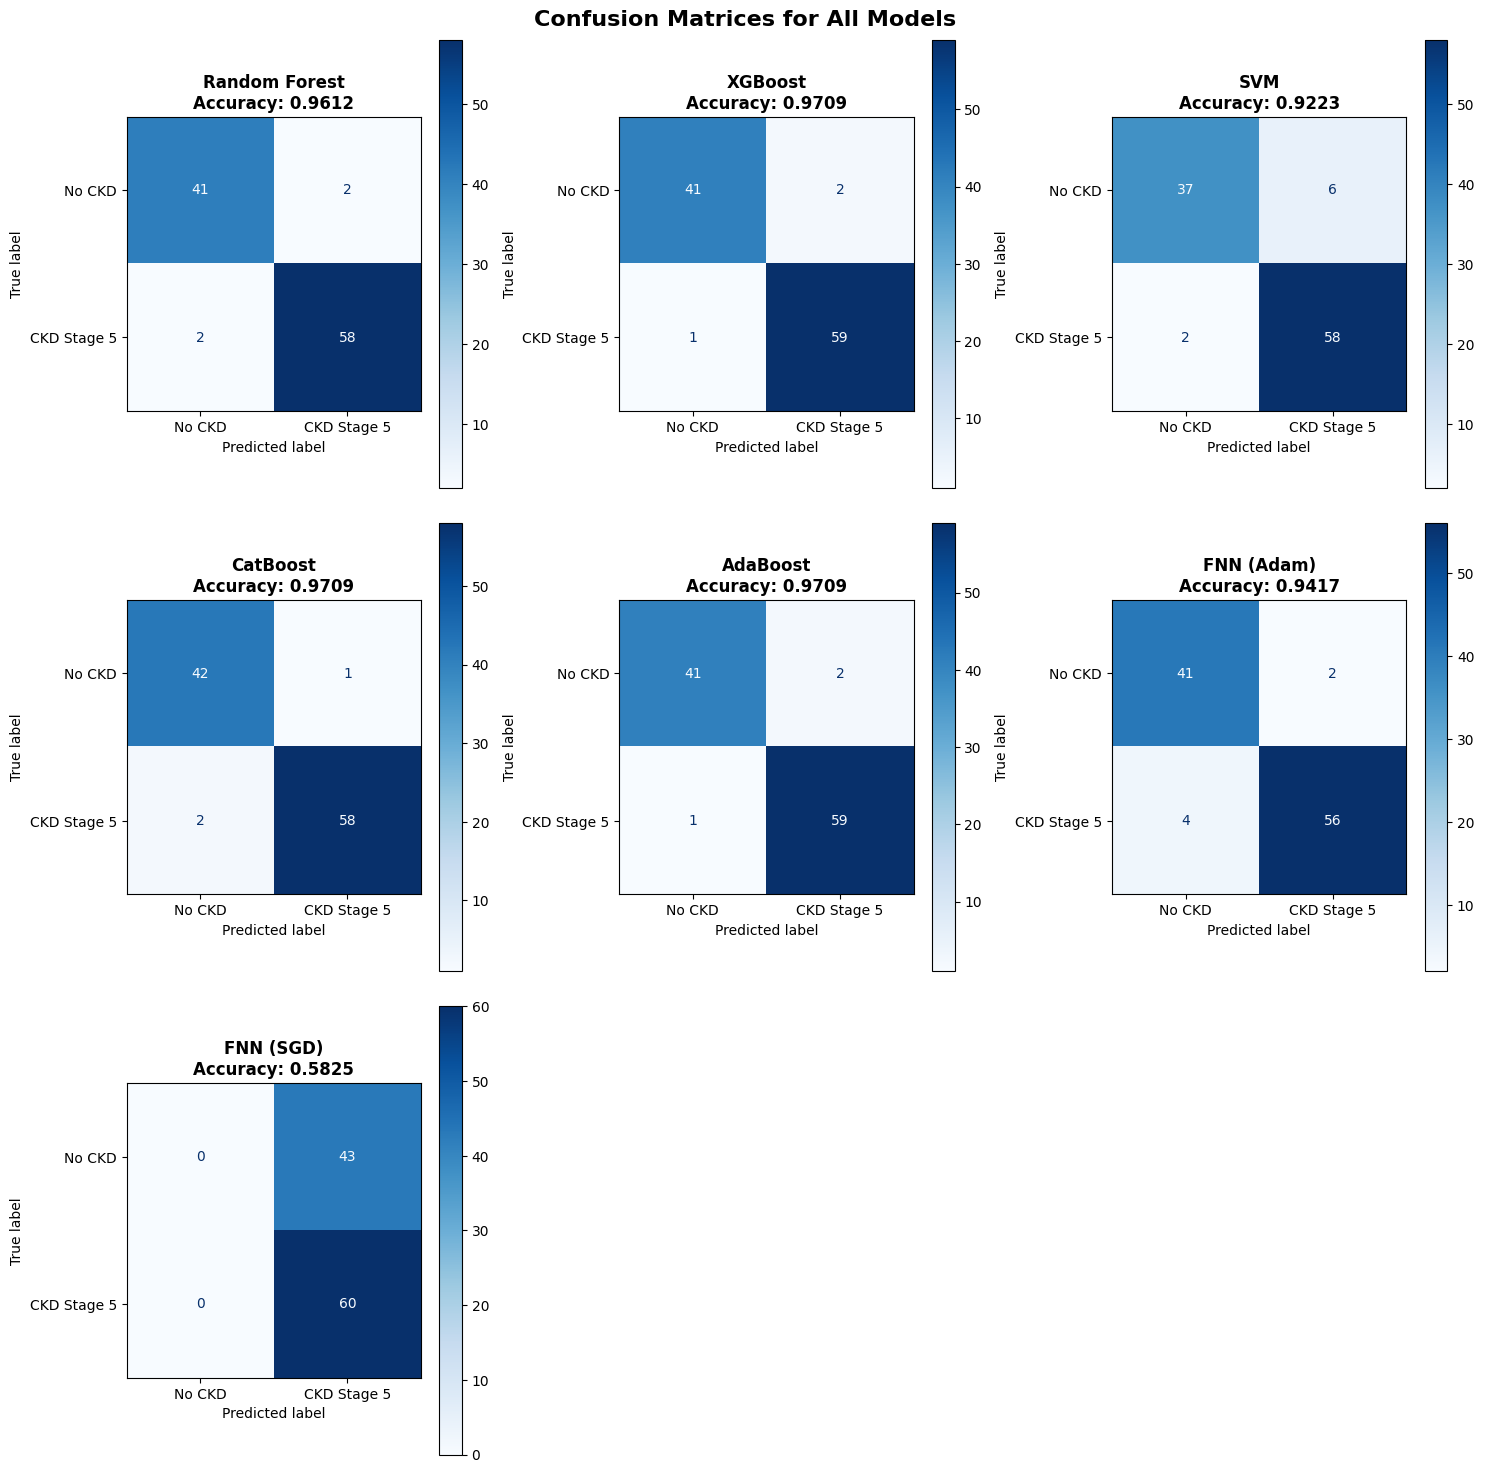

In [59]:
# Confusion Matrices for All Models
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

# Calculate number of subplots needed
n_models = len(models_results)
n_cols = 3
n_rows = (n_models + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)

fig.suptitle('Confusion Matrices for All Models', fontsize=16, fontweight='bold')

model_names = list(models_results.keys())

for idx, model_name in enumerate(model_names):
    row = idx // n_cols
    col = idx % n_cols
    ax = axes[row, col]
    
    y_pred = models_results[model_name]['test_predictions']
    cm = confusion_matrix(y_test, y_pred)
    
    # Create confusion matrix display
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                 display_labels=['No CKD', 'CKD Stage 5'])
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    
    ax.set_title(f'{model_name}\nAccuracy: {models_results[model_name]["test_accuracy"]:.4f}', 
                fontweight='bold')
    ax.grid(False)

# Hide empty subplots
for idx in range(len(model_names), n_rows * n_cols):
    row = idx // n_cols
    col = idx % n_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

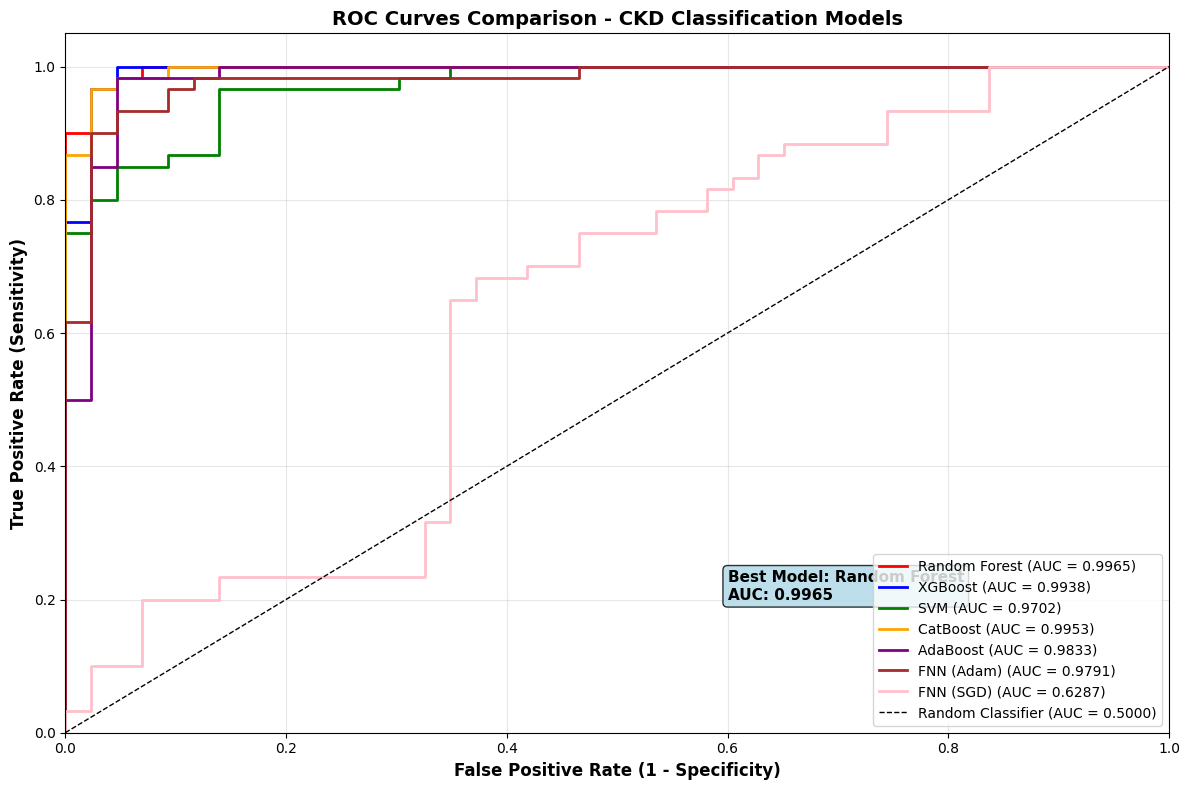

In [60]:
# ROC Curves for All Models
plt.figure(figsize=(12, 8))

# Colors for different models
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink']

for idx, model_name in enumerate(models_results.keys()):
    y_proba = models_results[model_name]['test_probabilities']
    test_auc = models_results[model_name]['test_auc']
    
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    
    # Plot ROC curve
    plt.plot(fpr, tpr, 
             color=colors[idx % len(colors)], 
             linewidth=2, 
             label=f'{model_name} (AUC = {test_auc:.4f})')

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier (AUC = 0.5000)')

# Customize plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate (Sensitivity)', fontsize=12, fontweight='bold')
plt.title('ROC Curves Comparison - CKD Classification Models', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)

# Add text box with best model info
best_model = max(models_results.keys(), key=lambda x: models_results[x]['test_auc'])
best_auc = models_results[best_model]['test_auc']
plt.text(0.6, 0.2, f'Best Model: {best_model}\nAUC: {best_auc:.4f}', 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.8),
         fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

In [61]:
# Model Performance Metrics Summary Table
print("="*90)
print("COMPREHENSIVE MODEL PERFORMANCE METRICS")
print("="*90)

# Calculate additional metrics for each model
from sklearn.metrics import precision_score, recall_score, f1_score

detailed_results = []

for model_name in models_results.keys():
    y_pred = models_results[model_name]['test_predictions']
    y_proba = models_results[model_name]['test_probabilities']
    
    # Calculate metrics
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    detailed_results.append({
        'Model': model_name,
        'Accuracy': models_results[model_name]['test_accuracy'],
        'Precision': precision,
        'Recall (Sensitivity)': recall,
        'F1-Score': f1,
        'AUC-ROC': models_results[model_name]['test_auc'],
        'Specificity': (confusion_matrix(y_test, y_pred)[0,0] / 
                       (confusion_matrix(y_test, y_pred)[0,0] + confusion_matrix(y_test, y_pred)[0,1]))
    })

# Create comprehensive results DataFrame
detailed_df = pd.DataFrame(detailed_results)
detailed_df = detailed_df.sort_values('AUC-ROC', ascending=False).reset_index(drop=True)

# Display formatted table
print("\nRanked by AUC-ROC Score:")
print("-" * 90)
print(f"{'Rank':<4} {'Model':<15} {'Accuracy':<9} {'Precision':<10} {'Recall':<8} {'F1-Score':<8} {'AUC-ROC':<8} {'Specificity':<10}")
print("-" * 90)

for idx, row in detailed_df.iterrows():
    print(f"{idx+1:<4} {row['Model']:<15} {row['Accuracy']:<9.4f} {row['Precision']:<10.4f} "
          f"{row['Recall (Sensitivity)']:<8.4f} {row['F1-Score']:<8.4f} {row['AUC-ROC']:<8.4f} {row['Specificity']:<10.4f}")

print("\n" + "="*90)
print(f"🏆 BEST MODEL: {detailed_df.iloc[0]['Model']} (AUC-ROC: {detailed_df.iloc[0]['AUC-ROC']:.4f})")
print("="*90)

COMPREHENSIVE MODEL PERFORMANCE METRICS

Ranked by AUC-ROC Score:
------------------------------------------------------------------------------------------
Rank Model           Accuracy  Precision  Recall   F1-Score AUC-ROC  Specificity
------------------------------------------------------------------------------------------
1    Random Forest   0.9612    0.9667     0.9667   0.9667   0.9965   0.9535    
2    CatBoost        0.9709    0.9831     0.9667   0.9748   0.9953   0.9767    
3    XGBoost         0.9709    0.9672     0.9833   0.9752   0.9938   0.9535    
4    AdaBoost        0.9709    0.9672     0.9833   0.9752   0.9833   0.9535    
5    FNN (Adam)      0.9417    0.9655     0.9333   0.9492   0.9791   0.9535    
6    SVM             0.9223    0.9062     0.9667   0.9355   0.9702   0.8605    
7    FNN (SGD)       0.5825    0.5825     1.0000   0.7362   0.6287   0.0000    

🏆 BEST MODEL: Random Forest (AUC-ROC: 0.9965)


FEATURE IMPORTANCE ANALYSIS


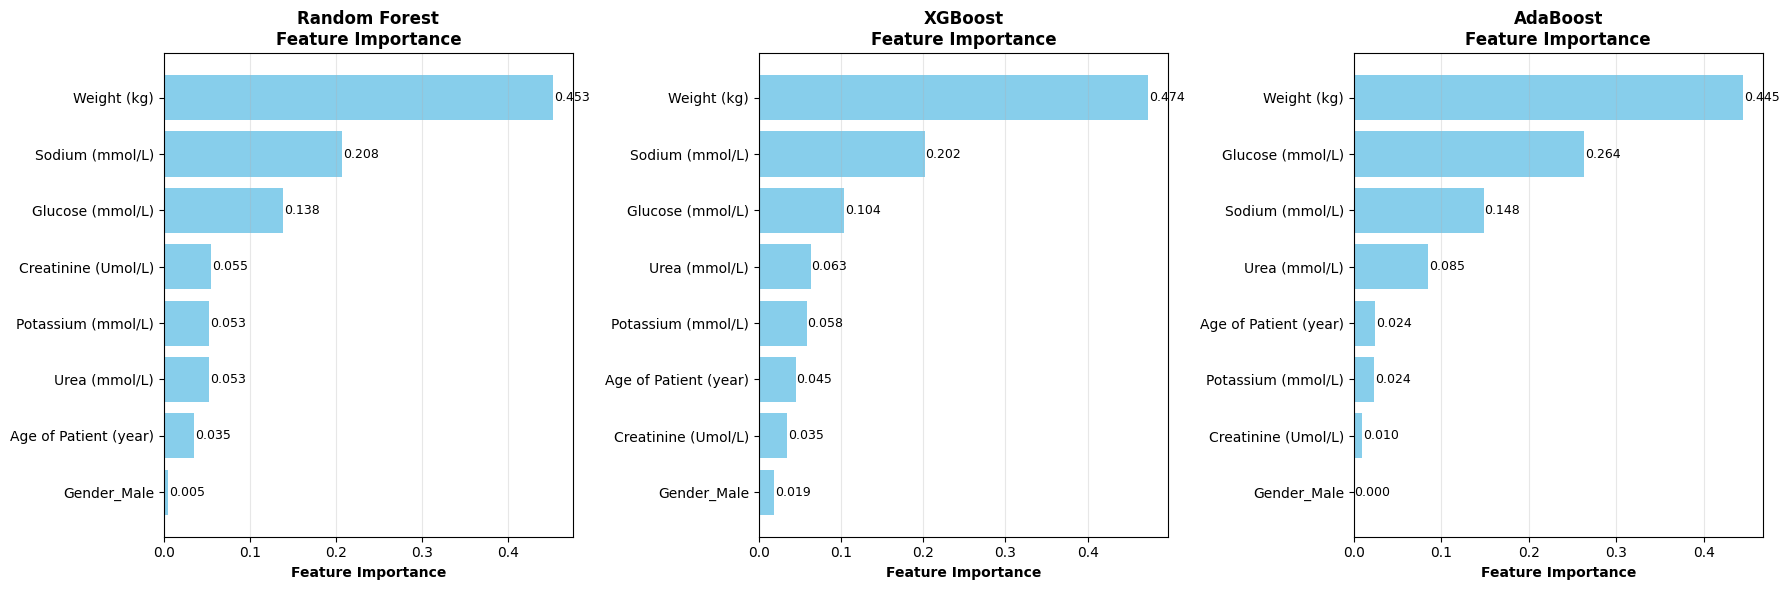


Top 5 Most Important Features by Model:
------------------------------------------------------------

Random Forest:
  1. Weight (kg): 0.4531
  2. Sodium (mmol/L): 0.2078
  3. Glucose (mmol/L): 0.1385
  4. Creatinine (Umol/L): 0.0550
  5. Potassium (mmol/L): 0.0529

XGBoost:
  1. Weight (kg): 0.4738
  2. Sodium (mmol/L): 0.2018
  3. Glucose (mmol/L): 0.1040
  4. Urea (mmol/L): 0.0630
  5. Potassium (mmol/L): 0.0584

AdaBoost:
  1. Weight (kg): 0.4455
  2. Glucose (mmol/L): 0.2635
  3. Sodium (mmol/L): 0.1484
  4. Urea (mmol/L): 0.0853
  5. Age of Patient (year): 0.0242


In [62]:
# Feature Importance Analysis (for applicable models)
print("="*80)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*80)

# Models that have feature importance
importance_models = {
    'Random Forest': rf_model,
    'XGBoost': xgb_model,
    'AdaBoost': ada_model
}

# Plot feature importance for tree-based models
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
feature_names = X_encoded.columns

for idx, (model_name, model) in enumerate(importance_models.items()):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        
        # Create DataFrame for easier plotting
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        }).sort_values('importance', ascending=True)
        
        # Plot horizontal bar chart
        axes[idx].barh(range(len(importance_df)), importance_df['importance'], color='skyblue')
        axes[idx].set_yticks(range(len(importance_df)))
        axes[idx].set_yticklabels(importance_df['feature'], fontsize=10)
        axes[idx].set_xlabel('Feature Importance', fontweight='bold')
        axes[idx].set_title(f'{model_name}\nFeature Importance', fontweight='bold')
        axes[idx].grid(axis='x', alpha=0.3)
        
        # Add importance values as text
        for i, v in enumerate(importance_df['importance']):
            axes[idx].text(v + 0.001, i, f'{v:.3f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

# Print top 5 most important features for each model
print("\nTop 5 Most Important Features by Model:")
print("-" * 60)

for model_name, model in importance_models.items():
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        }).sort_values('importance', ascending=False)
        
        print(f"\n{model_name}:")
        for i in range(min(5, len(importance_df))):
            print(f"  {i+1}. {importance_df.iloc[i]['feature']}: {importance_df.iloc[i]['importance']:.4f}")
            

In [63]:
# Save the Random Forest model and scaler for deployment
import joblib
import os

# Create models directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

# Save the trained Random Forest model
joblib.dump(rf_model, '../models/random_forest_model.pkl')
print("✅ Random Forest model saved to ../models/random_forest_model.pkl")

# Save the scaler
joblib.dump(scaler, '../models/scaler.pkl')
print("✅ Scaler saved to ../models/scaler.pkl")

# Save feature names for API reference
feature_names_list = X_encoded.columns.tolist()
joblib.dump(feature_names_list, '../models/feature_names.pkl')
print("✅ Feature names saved to ../models/feature_names.pkl")

print(f"\n📋 Model Features ({len(feature_names_list)}):")
for i, feature in enumerate(feature_names_list, 1):
    print(f"{i:2d}. {feature}")

print(f"\n🎯 Model Performance:")
print(f"   • Test Accuracy: {models_results['Random Forest']['test_accuracy']:.4f}")
print(f"   • Test AUC-ROC: {models_results['Random Forest']['test_auc']:.4f}")
print(f"\n✨ Model ready for deployment!")

✅ Random Forest model saved to ../models/random_forest_model.pkl
✅ Scaler saved to ../models/scaler.pkl
✅ Feature names saved to ../models/feature_names.pkl

📋 Model Features (8):
 1. Age of Patient (year)
 2. Weight (kg)
 3. Creatinine (Umol/L)
 4. Sodium (mmol/L)
 5. Potassium (mmol/L)
 6. Glucose (mmol/L)
 7. Urea (mmol/L)
 8. Gender_Male

🎯 Model Performance:
   • Test Accuracy: 0.9612
   • Test AUC-ROC: 0.9965

✨ Model ready for deployment!
